<a href="https://colab.research.google.com/github/jeremi0214/DATA425_Assignment2/blob/main/mobilenetv2-flowers-jc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nasnet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# === CONFIGURATION ===
INITIAL_LR = 0.003
WARMUP_EPOCHS = 3
DECAY_RATE = 0.95
TOTAL_EPOCHS = 30
WEIGHT_DECAY = 1e-5
EMA_DECAY = 0.99
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
NUM_CLASSES = 102

In [4]:
# === CUSTOM SGD OPTIMIZER WITH WEIGHT DECAY ===
class SGDWithWeightDecay(tf.keras.optimizers.SGD):
    def __init__(self, weight_decay=0.0, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def apply_gradients(self, grads_and_vars, **kwargs):
        super().apply_gradients(grads_and_vars, **kwargs)
        for grad, var in grads_and_vars:
            if grad is not None and self.weight_decay > 0:
                var.assign_sub(self.weight_decay * var)

In [5]:
# ========= Learning Rate Schedule =========
def lr_schedule(epoch):
    if epoch < WARMUP_EPOCHS:
        return INITIAL_LR * (epoch + 1) / WARMUP_EPOCHS
    else:
        return INITIAL_LR * (DECAY_RATE ** (epoch - WARMUP_EPOCHS + 1))

lr_callback = LearningRateScheduler(lr_schedule)

In [6]:
# === LOAD DATASET ===
def load_dataset(name="oxford_flowers102", img_size=(224, 224), batch_size=64):
    def preprocess(example):
        image = tf.image.resize(example["image"], img_size)
        label = example["label"]
        return image, label

    train_ds = tfds.load(name, split="train", as_supervised=False)
    val_ds = tfds.load(name, split="validation", as_supervised=False)

    train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds

In [7]:
# === CREATE MODEL ===
def create_model(base_model_fn, input_shape=(224, 224, 3), num_classes=102, preprocess_fn=None, trainable=False, weights_path='imagenet'):
    base_model = base_model_fn(include_top=False, weights=weights_path, input_shape=input_shape)
    base_model.trainable = trainable

    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_fn(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    optimizer = SGDWithWeightDecay(
        learning_rate=INITIAL_LR,
        momentum=0.9,
        nesterov=True,
        weight_decay=WEIGHT_DECAY
    )

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# === TRAIN AND EVALUATE ===
def train_and_evaluate(model, train_ds, val_ds, epochs=TOTAL_EPOCHS):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True),
            lr_callback
        ]
    )

    val_preds = model.predict(val_ds)
    y_true = np.concatenate([y for _, y in val_ds])
    y_pred = np.argmax(val_preds, axis=1)
    acc = accuracy_score(y_true, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    return history, acc

In [9]:
# === DATA VISUALISATION ===
def plot_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.LJ2NJI_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.LJ2NJI_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.LJ2NJI_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training MobileNetV2...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.0146 - loss: 5.0394 - val_accuracy: 0.0176 - val_loss: 4.7979 - learning_rate: 0.0010
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.0120 - loss: 4.7818 - val_accuracy: 0.0461 - val_loss: 4.4915 - learning_rate: 0.0020
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0337 - loss: 4.4336 - val_accuracy: 0.1049 - val_loss: 4.1312 - learning_rate: 0.0030
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.1372 - loss: 4.0054 - val_accuracy: 0.2216 - val_loss: 3.7752 - learning_rate: 0.0029
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.2841 - loss: 3.5894 - val_accuracy: 0.3343 - val_loss: 3.4565 - learning_rate: 0.0027
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━

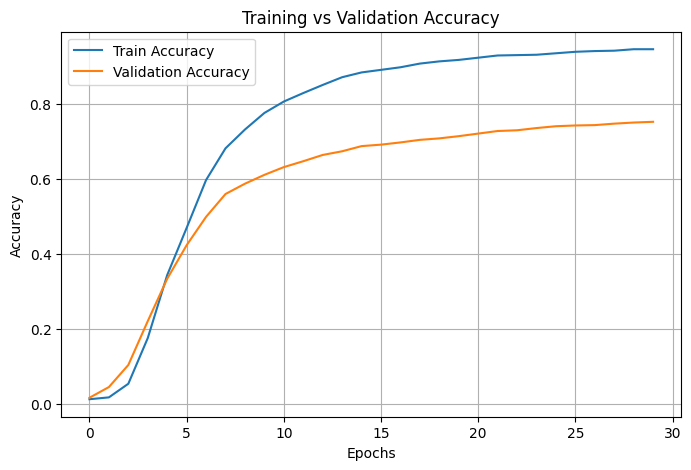

In [10]:
# === RUN PIPELINE ===
train_ds, val_ds = load_dataset("oxford_flowers102", img_size=IMG_SIZE, batch_size=BATCH_SIZE)

# === Choose model ===

# Option 1: MobileNetV2
mobilenet_model = create_model(MobileNetV2, num_classes=NUM_CLASSES, preprocess_fn=preprocess_mobilenet)
print("Training MobileNetV2...")
history, acc = train_and_evaluate(mobilenet_model, train_ds, val_ds)
plot_history(history)